In [1]:
import pandas as pd
from pathlib import Path
import matplotlib as plt
import numpy as np
import sqlalchemy
import yfinance as yf
import yahoo_fin.stock_info as si
import os
import panel as pn


In [2]:
# Using the Pandas read_csv funcion and the Path module, 
# read "sp500_sustainability_scores.csv" file into a Pandas DataFrame
esg_df = pd.read_csv(
    Path("sp500_sustainability_scores.csv")
)

# Review the DataFrame
esg_df.head()

,Unnamed: 0,palmOil,controversialWeapons,gambling,socialScore,nuclear,furLeather,alcoholic,gmo,catholic,...,coal,pesticides,adult,percentile,peerGroup,smallArms,environmentScore,governancePercentile,militaryContract,company_ticker
0,Value,False,False,False,8.65,False,False,False,False,True,...,False,False,False,10.48,Pharmaceuticals,False,0.34,0,False,A
1,Value,False,False,False,12.31,False,False,False,False,False,...,False,False,False,58.47,Transportation,False,11.53,0,False,AAL
2,Value,False,False,False,9.17,False,False,False,False,False,...,False,False,False,5.74,Retailing,False,0.10,0,False,AAP
3,Value,False,False,False,6.86,False,False,False,False,False,...,False,False,False,12.87,Technology Hardware,False,0.65,0,False,AAPL
4,Value,False,False,False,16.92,False,False,False,False,True,...,False,False,False,53.78,Pharmaceuticals,False,1.12,0,False,ABBV


In [3]:
# Create the connection string for your SQLite database
database_connection_string = 'sqlite:///'

# Pass the connection string to the SQLAlchemy create_engine function
engine = sqlalchemy.create_engine(database_connection_string)

# Confirm that the database engine was created.
engine

Engine(sqlite:///)

In [4]:
esg_df.to_sql(
    'esg_score_info', #New table name
    engine, 
    index=False, 
    if_exists='replace'
)

# Confirm that the table was created by calling the table_names function
engine.table_names()

C:\Projects\Softwares\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:9: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  if __name__ == '__main__':


['esg_score_info']

In [5]:
# e_score = 10
# s_score = 10
# g_score = 8

# Create and execute a query to return all columns for the 10 highest credit scores.
# query1 = """
# SELECT company_ticker, environmentScore, socialScore, governanceScore
# FROM esg_score_info
# WHERE environmentScore >= """+str(e_score)+""" AND socialScore >= """+str(s_score)+""" AND governanceScore >= """+str(g_score)+""";
# """

## , environmentScore, socialScore, governanceScore

# Call on the database engine to execute the query
# results = engine.execute(query1)

# List of the results of the database query
# list(results)

# Choose the filter for each category of ESG

In [6]:
pn.extension()

In [7]:
# Create sliders for each category of ESG
e_score_slider = pn.widgets.IntSlider(name='Environmental Score Slider', start=0, end=20, step=1, value=10)
s_score_slider = pn.widgets.IntSlider(name='Social Score Slider', start=0, end=20, step=1, value=10)
g_score_slider = pn.widgets.IntSlider(name='Governance Score Slider', start=0, end=20, step=1, value=10)

**Please adjust the slider for** *environmental* **score**

In [8]:
e_score_slider

IntSlider(end=20, name='Environmental S..., value=10)

**Please adjust the slider for** *social* **score**

In [9]:
s_score_slider

IntSlider(end=20, name='Social Score Slider', value=10)

**Please adjust the slider for** *governance* **score**

In [10]:
g_score_slider

IntSlider(end=20, name='Governance Score Slider', value=10)

# Create a custom index for FILTERED stock in the S&P500

In [11]:
e_score = e_score_slider.value
s_score = s_score_slider.value
g_score = g_score_slider.value

# Create and execute a query to return esg data for tickers that match the chosen criteria.
query1 = """
SELECT company_ticker, environmentScore, socialScore, governanceScore
FROM esg_score_info
WHERE environmentScore >= """+str(e_score)+""" AND socialScore >= """+str(s_score)+""" AND governanceScore >= """+str(g_score)+""";
"""

# read in your SQL query results using pandas
esg_df = pd.read_sql(query1, con=engine)

# return your first five rows
esg_df.head()

,company_ticker,environmentScore,socialScore,governanceScore
0,GE,14.09,15.04,11.58
1,TSN,14.31,12.39,10.53


In [12]:
esg_ticker = esg_df['company_ticker']

#Download historical data for S&P 500
sp500_hist_data = yf.download(list(esg_ticker), start="2020-01-01", end="2020-04-30")

#Count the number of column fetched
column_count = (len(sp500_hist_data.columns))/6

#Fetch only the "Adjusted Closing Price" from the data frame
sp500_hist_data_closing = sp500_hist_data.iloc[:,0:int(column_count)]

#Print the data frame to make sure the data is fetched correctly
sp500_hist_data_closing

[*********************100%***********************]  2 of 2 completed


Adj Close           
                   GE        TSN
Date                            
2020-01-02  95.204353  85.615974
2020-01-03  95.523560  86.196457
2020-01-06  96.880219  85.787270
2020-01-07  96.161980  84.540665
2020-01-08  95.284157  85.064041
...               ...        ...
2020-04-23  52.037674  58.297218
2020-04-24  49.962547  56.459270
2020-04-27  51.319355  57.129360
2020-04-28  54.272415  60.116013
2020-04-29  52.516544  60.594643

[82 rows x 2 columns]

In [13]:
#Create the "Custom_Index" column to calculate the average price of all the filtered stock
sp500_hist_data_closing['custom_index'] = sp500_hist_data_closing.mean(axis=1)

#Select only the average price of all fetch stocks
position_of_avg_price = len(sp500_hist_data_closing.columns)

#Select only date and price
sp500_hist_data_closing_only = sp500_hist_data_closing.iloc[:,int(position_of_avg_price)-1]

#Print the data frame to make sure the data is fetched correctly
sp500_hist_data_closing_only

#Find the division factor to transform the data to base 100 for easy comparison
division_factor_filtered_sp500 = sp500_hist_data_closing_only.iloc[0]

#Transform closing price into base 100 for easy comparison
sp500_hist_data_closing_only = (sp500_hist_data_closing_only/division_factor_filtered_sp500)*100

#Print the data frame to make sure the data is manipulated correctly
sp500_hist_data_closing_only.head()

Date
2020-01-02    100.000000
2020-01-03    100.497560
2020-01-06    101.021545
2020-01-07     99.934917
2020-01-08     99.738896
Name: (custom_index, ), dtype: float64

# Compute the index for ALL stocks in the S&P500

In [14]:
# Fetch the data for ALL S&P 500 as an index for comparison

# Create and execute a query to return the list of tickers for S&P 500
query_all_sp500 = """
SELECT company_ticker
FROM esg_score_info
"""

# read in your SQL query results using pandas
all_sp500_df = pd.read_sql(query_all_sp500, con=engine)
all_sp500_ticker = all_sp500_df['company_ticker']

#Download historical data for S&P 500
all_sp500_hist_data = yf.download(list(all_sp500_ticker), start="2020-01-01", end="2020-04-30")


[*********************100%***********************]  446 of 446 completed


In [15]:
#Count the number of column fetched
all_sp500_column_count = (len(all_sp500_hist_data.columns))/6

#Fetch only the "Adjusted Closing Price" from the data frame
all_sp500_hist_data_closing = all_sp500_hist_data.iloc[:,0:int(all_sp500_column_count)]

#Print the data frame to make sure the data is fetched correctly
all_sp500_hist_data_closing.head()


Adj Close                                                          \
                    A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2020-01-02  84.799675  28.982893  155.478271  74.207466  80.137352  82.064140   
2020-01-03  83.438141  27.548195  155.488022  73.486023  79.376678  81.032082   
2020-01-06  83.684799  27.219410  152.932632  74.071579  80.003105  82.218468   
2020-01-07  83.941315  27.119778  151.118530  73.723213  79.546707  81.630096   
2020-01-08  84.770073  27.737495  149.382446  74.909149  80.110497  82.421021   

                                                           ...              \
                  ABT         ACN        ADBE         ADI  ...         WTW   
Date                                                       ...               
2020-01-02  84.001160  203.776108  334.429993  116.998917  ...  204.279999   
2020-01-03  82.977119  203.436722  331.809998  114.939316  ...  204.330002   
2020-01-06  83.411850  202.108276  333.709991  113.588921  ...  204.580002   
2020-01-07  82.948128  197.744766  333.390015  116.173134  ...  204.160004   
2020-01-08  83.286255  198.132614  337.869995  117.222366  ...  204.389999   

                                                                               \
                   WY        WYNN        XEL        XOM       XRAY        XYL   
Date                                                                            
2020-01-02  26.965099  142.405029  59.119480  61.174892  55.990772  77.805450   
2020-01-03  27.010975  140.292755  59.403793  60.683083  55.371174  78.263412   
2020-01-06  26.955923  140.015091  59.318501  61.149014  55.676056  77.756737   
2020-01-07  26.781599  140.679504  59.195293  60.648575  55.971104  77.464417   
2020-01-08  26.882524  141.562103  59.138432  59.733971  56.561207  77.727501   

                                               
                  YUM         ZBH         ZTS  
Date                                           
2020-01-02  98.133003  147.066025  132.432312  
2020-01-03  97.825630  146.681580  132.452057  
2020-01-06  97.768005  145.833908  131.435150  
2020-01-07  97.940903  145.705765  131.879440  
2020-01-08  98.113785  147.450455  131.593124  

[5 rows x 446 columns]

In [16]:
#Create the "Custom_Index" column to calculate the average price of ALL stock in S&P500
all_sp500_hist_data_closing['custom_index'] = all_sp500_hist_data_closing.mean(axis=1)

#Select only the average price of all fetch stocks
all_position_of_avg_price = len(all_sp500_hist_data_closing.columns)

#Select only date and price
all_sp500_hist_data_closing_only = all_sp500_hist_data_closing.iloc[:,int(all_position_of_avg_price)-1]

#Find the division factor to transform the data to base 100 for easy comparison
division_factor_all_sp500 = all_sp500_hist_data_closing_only.iloc[0]

#Transform closing price into base 100 for easy comparison
all_sp500_hist_data_closing_only = (all_sp500_hist_data_closing_only/division_factor_all_sp500)*100

#Print the data frame to make sure the data is manipulated correctly
all_sp500_hist_data_closing_only.head()

Date
2020-01-02    100.000000
2020-01-03     99.612927
2020-01-06     99.804079
2020-01-07     99.705320
2020-01-08    100.090551
Name: (custom_index, ), dtype: float64

# Combine the data to plot in a line graph


<AxesSubplot:title={'center':'The Price Index of Stock Filtered [E score >= 10 ; S score >= 10; G score >= 10]'}, xlabel='Date', ylabel='Price Index'>

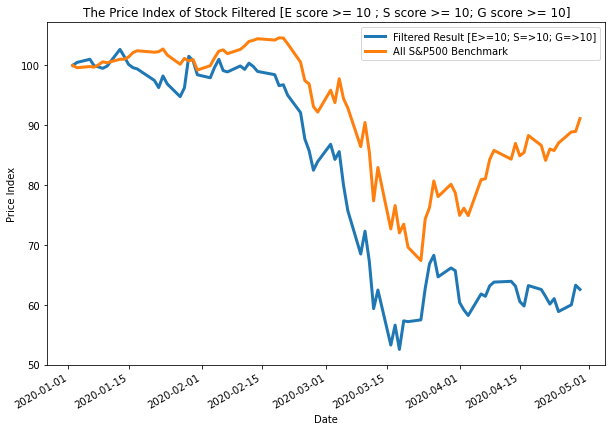

In [17]:
#Plot the filtered data frame
sp500_hist_data_closing_only.plot(
    title=f"The Price Index of Stock Filtered [E score >= {e_score} ; S score >= {s_score}; G score >= {g_score}]", 
    xlabel="Date", 
    ylabel="Price Index", 
    figsize=(10,7),
    legend="top",
    label=f"Filtered Result [E>={e_score}; S=>{s_score}; G=>{g_score}]",
    linewidth=3
)

#Plot the "ALL" S&P500 index data frame
all_sp500_hist_data_closing_only.plot(
    legend="top",
    label="All S&P500 Benchmark",
    linewidth=3
)

In [18]:
# To do
# -------
# table and column name for industry
# integrate the SQL code with streamlit